# Import and Load Data

In [32]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU, Add
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dataset Path
DATASET_DIR = r"C:\Users\Aalla\Downloads\archive\The IQ-OTHNCCD lung cancer dataset\The IQ-OTHNCCD lung cancer dataset"
IMG_SIZE = (128, 128)
INPUT_SHAPE = (*IMG_SIZE, 3)

# Automatically determine the number of classes from the dataset structure
class_names = sorted(os.listdir(DATASET_DIR))
NUM_CLASSES = len(class_names)
print(f"Detected {NUM_CLASSES} classes: {class_names}")

BATCH_SIZE = 32
EPOCHS = 50

# Load and preprocess images
def load_data(dataset_path, input_shape):
    """
    Function to load images and labels from the dataset directory.

    Parameters:
    - dataset_path: Path to the main dataset directory containing class subfolders.
    - input_shape: Tuple representing the desired shape for each image (height, width, channels).

    Returns:
    - data: Array of processed image data.
    - labels: One-hot encoded labels corresponding to the class of each image.
    - class_names: List of class names in sorted order.
    """
    data, labels = [], []
    class_names = sorted(os.listdir(dataset_path))  # Ensure consistent ordering of class names
    print("Classes Found:", class_names)
    class_to_index = {name: idx for idx, name in enumerate(class_names)}  # Map class names to numeric labels
    
    for class_name in class_names:
        class_dir = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_dir):
            print(f"Processing class: {class_name}")
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                try:
                    # Open image, resize it, and convert it to a NumPy array
                    img = Image.open(file_path).resize(input_shape[:2])
                    data.append(np.array(img))  # Add the image data to the list
                    labels.append(class_to_index[class_name])  # Add the corresponding class index
                except Exception as e:
                    print(f"Error loading {file_name}: {e}")
    
    print(f"Total images loaded: {len(data)}")
    
    # Normalize image data to the range [0, 1] and convert labels to one-hot encoding
    return (np.array(data, dtype=np.float32) / 255.0,
            tf.keras.utils.to_categorical(labels, num_classes=len(class_names)),
            class_names)

# Load the dataset
images, labels, class_names = load_data(DATASET_DIR, INPUT_SHAPE)

# Verify loaded data
print("Images Shape:", images.shape)
print("Labels Shape:", labels.shape)

Detected 4 classes: ['Bengin cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Normal cases']
Classes Found: ['Bengin cases', 'IQ-OTH_NCCD lung cancer dataset.txt', 'Malignant cases', 'Normal cases']
Processing class: Bengin cases
Processing class: Malignant cases
Processing class: Normal cases
Total images loaded: 1097
Images Shape: (1097, 128, 128, 3)
Labels Shape: (1097, 4)


# Build and Train Model

In [33]:
# Shuffle and split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.20, random_state=42)

# Define CNN model
def build_model(input_shape, num_classes):
    """
    Builds a CNN model with residual blocks for classifying lung cancer images.

    Parameters:
    - input_shape: Shape of the input image (height, width, channels).
    - num_classes: Number of output classes.

    Returns:
    - model: Compiled Keras model.
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', name="conv_layer_1")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Residual block
    shortcut = x
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut])
    x = ReLU()(x)

    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Build the model
model = build_model(INPUT_SHAPE, NUM_CLASSES)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy')

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.5300 - loss: 14.0652 - val_accuracy: 0.4318 - val_loss: 1.0007
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5923 - loss: 0.9236 - val_accuracy: 0.4318 - val_loss: 1.0408
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.6763 - loss: 0.6984 - val_accuracy: 0.4591 - val_loss: 0.9170
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7515 - loss: 0.5731 - val_accuracy: 0.4273 - val_loss: 1.1235
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7666 - loss: 0.5638 - val_accuracy: 0.4227 - val_loss: 1.1532
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8188 - loss: 0.4221 - val_accuracy: 0.4318 - val_loss: 1.2601
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.8101 - loss: 0.4618 - val_accuracy: 0.4318 - val_loss: 1.1364
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.7836 - loss: 0.5004 - val_accuracy: 0

# Evaluate Model

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 1.0000 - loss: 0.0146
Test Loss: 0.014412823133170605, Test Accuracy: 1.0


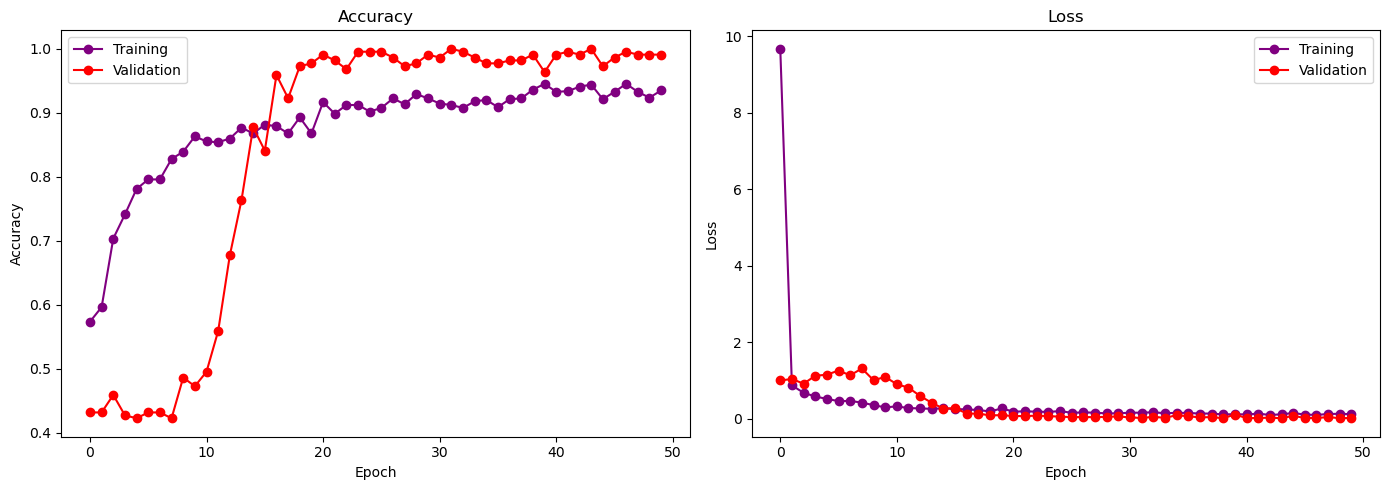

In [34]:
# Refrence https://www.kaggle.com/code/samsomhassan/cnn-lung-cancer

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Plot training history with custom colors
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss over epochs with custom colors.

    Parameters:
    - history: Keras History object containing training metrics.
    """
    plt.figure(figsize=(14, 5))

    # Custom colors for the accuracy plot
    accuracy_color = '#800080'
    val_accuracy_color = '#FF0000'

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training', color=accuracy_color, marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation', color=val_accuracy_color, marker='o')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training', color=accuracy_color, marker='o')
    plt.plot(history.history['val_loss'], label='Validation', color=val_accuracy_color, marker='o')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Confusion Matrix

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


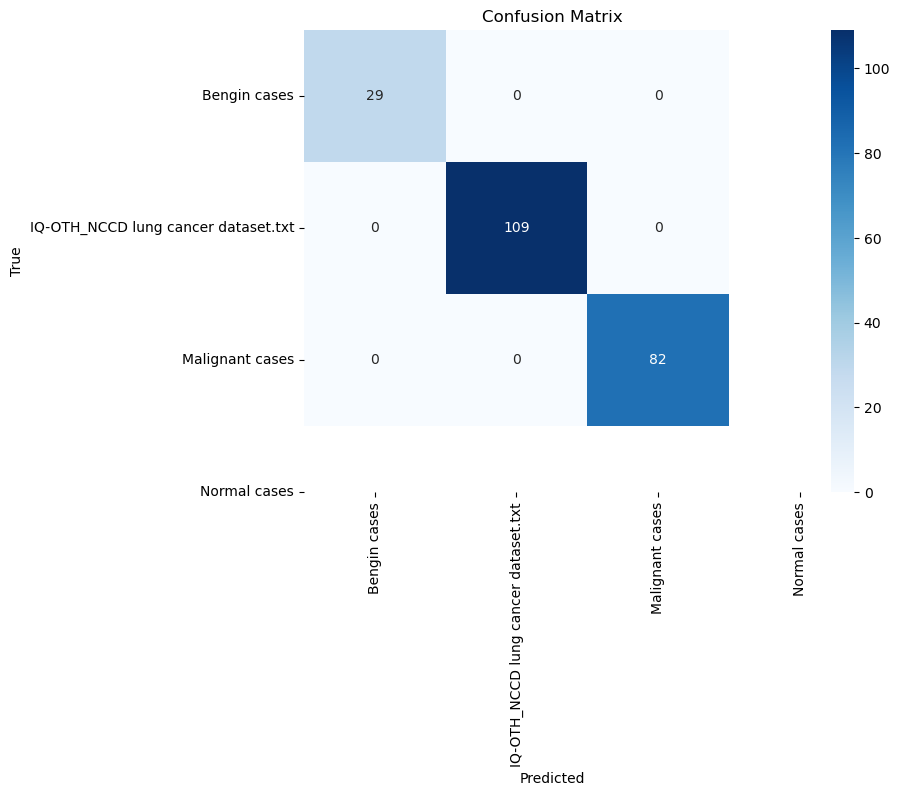

In [35]:
# Confusion matrix
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Show Filter Sample 1

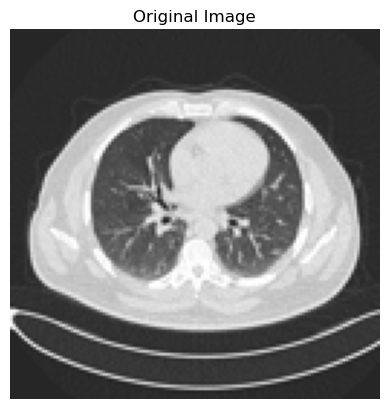

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Feature map size: 128x128, Number of filters: 32


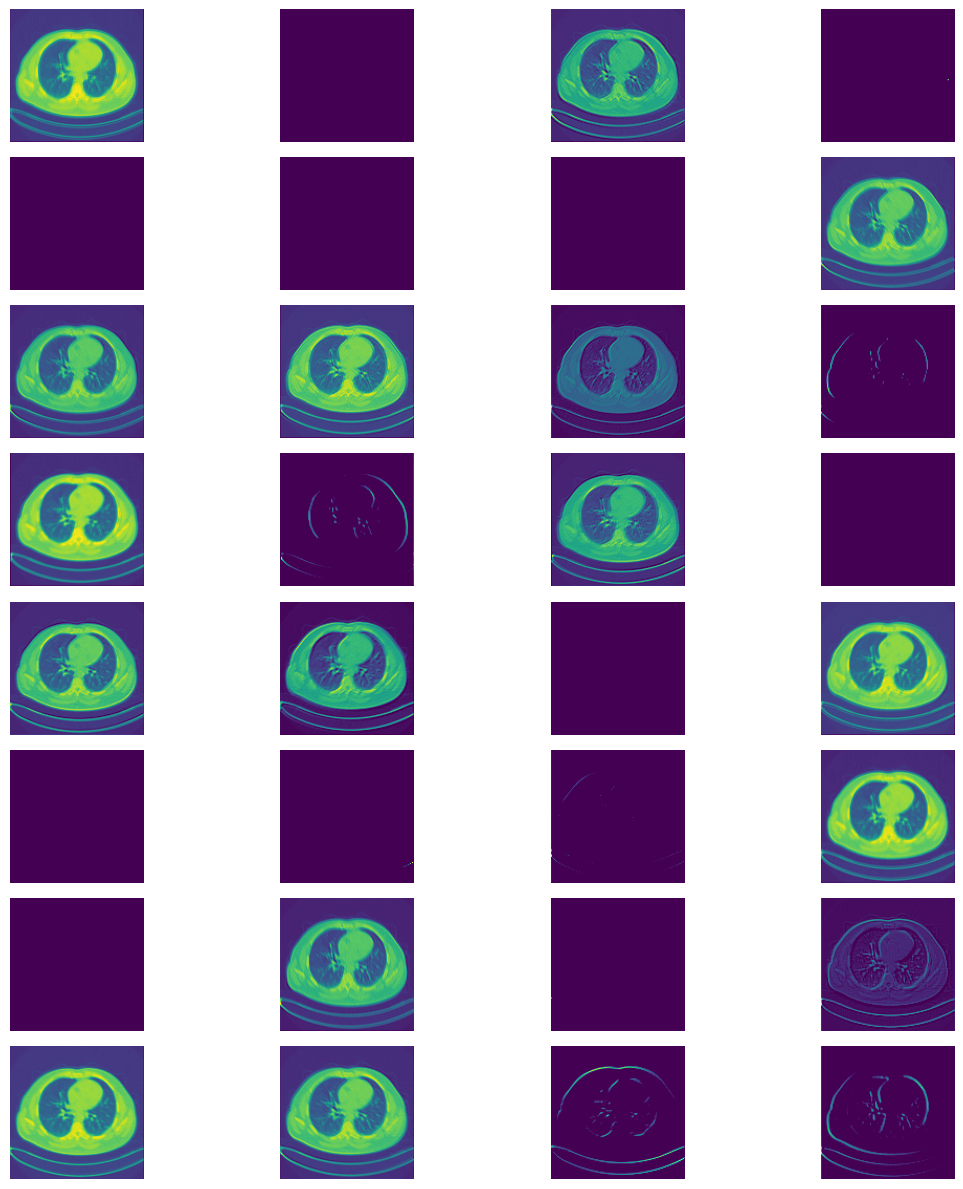

In [36]:
# Visualize all feature maps of the first convolutional layer
def visualize_all_feature_maps(model, image):
    """
    Visualizes all feature maps from the first convolutional layer for a given image.

    Parameters:
    - model: Trained Keras model.
    - image: Input image to analyze.
    """
    # Extract the first convolutional layer's output
    layer_output = model.get_layer("conv_layer_1").output
    activation_model = Model(inputs=model.input, outputs=layer_output)
    
    # Get feature maps for the input image
    img = np.expand_dims(image, axis=0)
    feature_maps = activation_model.predict(img)
    
    num_filters = feature_maps.shape[-1]
    size = feature_maps.shape[1]
    print(f"Feature map size: {size}x{size}, Number of filters: {num_filters}")
    
    plt.figure(figsize=(12, 12))
    for i in range(num_filters):
        plt.subplot(8, 4, i + 1)  # Adjust grid based on number of filters
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize feature maps for a sample test image
sample_image = x_test[0]
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

visualize_all_feature_maps(model, sample_image)

Show CNN filter Sample 2

# Show Filter Sample 2

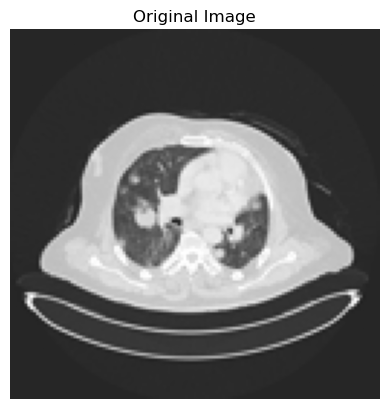

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Feature map size: 128x128, Number of filters: 32


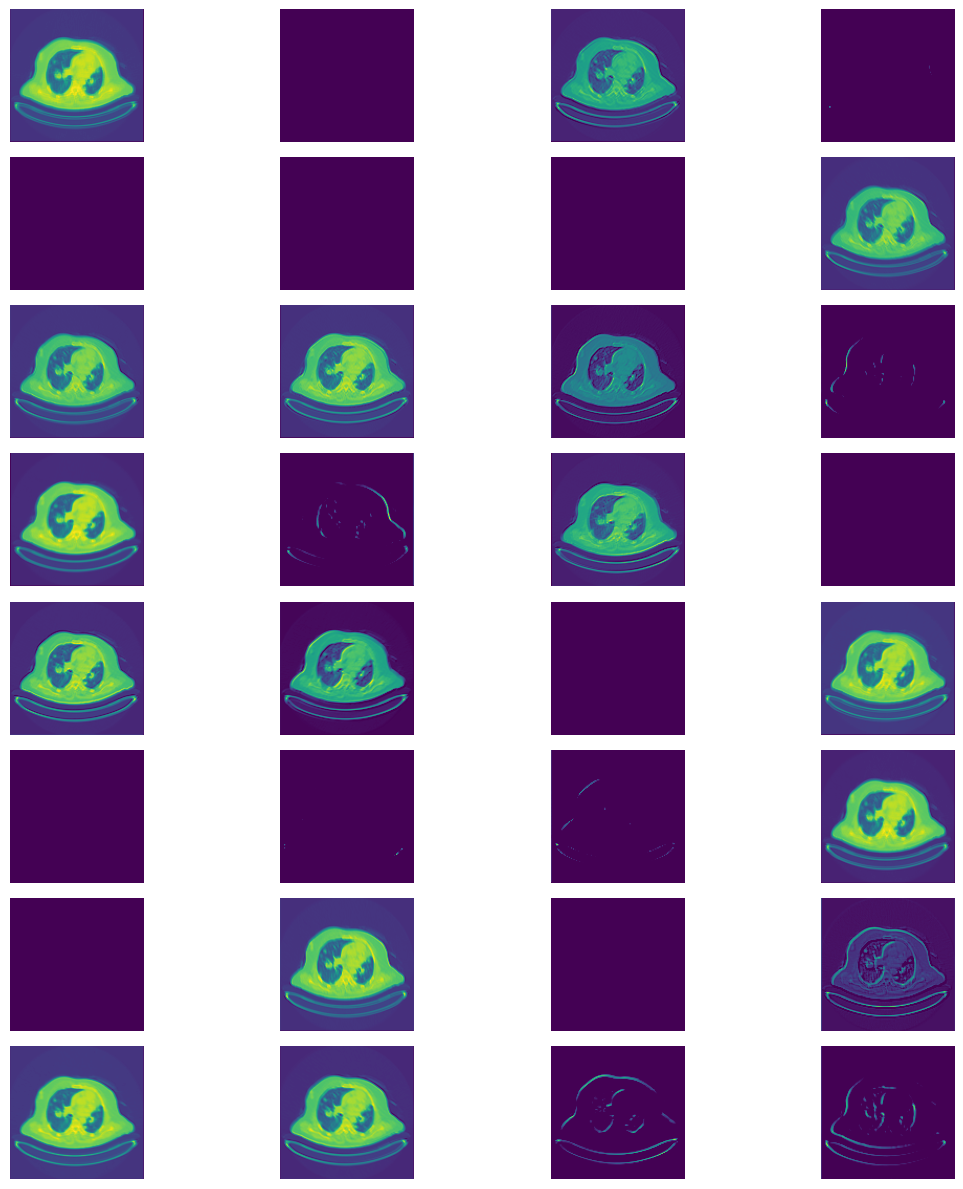

In [37]:
# Visualize feature maps for a sample test image
sample_image = x_test[60]
plt.imshow(sample_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

visualize_all_feature_maps(model, sample_image)